# Programa para calcular difusión, con malla triangular

## Queremos calcular la difusión evaluando la siguiente ecuación:
### $$u_i^{n+1}= u_1^n - \frac{dt}{Area_i}\sum D_f \frac{u_j -u_i}{\delta_f} - \frac{dt}{Area_i}\sum D_B \frac{u_B -u_i}{\delta_B}  $$


In [1]:
import numpy as np
import openmesh as om
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import seaborn as sns  #graficar datos de pandas
from pylab import savefig


##  Creamos la malla:
### - Cordenadas de los vertices
### - Celdas (compuestas por tres vertices)

In [2]:

mesh = om.TriMesh()


vh0 = mesh.add_vertex([0, 0, 0])
vh1 = mesh.add_vertex([0, 6, 0])
vh2 = mesh.add_vertex([0, 12, 0])
vh3 = mesh.add_vertex([8, 12, 0])
vh4 = mesh.add_vertex([16, 12, 0])
vh5 = mesh.add_vertex([16, 5, 0])
vh6 = mesh.add_vertex([16, 0, 0])
vh7 = mesh.add_vertex([6, 0, 0])

vh8 = mesh.add_vertex([4, 4, 0])
vh9 = mesh.add_vertex([9, 4, 0])
vh10 = mesh.add_vertex([10, 6, 0])

#Celdas
fh0 = mesh.add_face(vh0, vh8, vh1)
fh1 = mesh.add_face(vh9, vh1, vh8)
fh2 = mesh.add_face(vh2, vh1, vh9)
fh3 = mesh.add_face(vh3, vh2, vh9)
fh4 = mesh.add_face(vh10, vh3, vh9)
fh5 = mesh.add_face(vh4, vh3, vh10)
fh6 = mesh.add_face(vh5, vh4, vh10)
fh7 = mesh.add_face(vh8, vh0, vh7)
fh8 = mesh.add_face(vh10, vh8, vh7)
fh9 = mesh.add_face(vh6, vh10, vh7)
fh10 = mesh.add_face(vh5, vh10, vh6)
fh11 = mesh.add_face(vh8, vh10, vh9)

#Generar archivo
om.write_mesh('test.off', mesh)
mesh_2 = om.read_trimesh('test.off')


## Datos relevantes:
### - Indice
### - Celdas vecinas
### - Lados correspondientes

In [3]:
#Vertices correspondientes a cada celda
for vh in mesh.vertices():    
    v = mesh.point(vh)
    #print(v)

#Número de interfaces (lados)
Int = 0
for eh in mesh.edges(): #eh = interfaces
    Int = Int + 1  

#print('La cantidad de interfaces es:',Int)

#Información por cada celda
for fh in mesh.faces():  
    index = fh.idx() 
    #print("Cara: ",index)
    
    #Recorrer los vertices de cada cara y mostrar sus indices
    for vh in mesh.fv(fh):
        indx = vh.idx() 
        #print(indx)
    #Mostrar las celdas vecinas    
    for fh in mesh.ff(fh):
        VCel = fh.idx() 
        #print(VCel)
    #mostrar los lados correspondientes a cada celda    
    for eh in mesh.fe(fh):
        Lad = eh.idx()
        #print('Lados',Lad)

        
print('El numero de caras es: ', index +1)      

El numero de caras es:  12


## Generar arreglos vacios para utilizarlos posteriormente

In [4]:
#longitud de los lados
Longitud = np.zeros(Int)

#Áreas de las celdas
Area = []

#Centros de cada lado (Coordenada horizontal y vertical)
Centrox  = np.zeros(Int)
Centroy  = np.zeros(Int)

#Baricentros de las celdas (Coordenada horizontal y vertical) 
BariX = []
BariY = []

#Normales (Coordenada horizontal y vertical) 
NormalX = []
NormalY = []

#Distancia centro de las celda a centro de los lados
DCenLad = []

#Distancia nodos a centro de las celdas
DNodoCel = np.zeros((index-1,index+1))

#Relacion celda y sus bordes
CelBord = np.zeros((index +1,3))

#Relacion celda a celdas vecinas
CelCels = np.zeros((index +1,3))

#Relacion celda vertices
CelVer = np.zeros((index +1,3))

#Sumatoria de los inversos de las distancias nodo - centro (parte del método de volumenes finitos)
Suminv = []

## Cálculos de:
- Longitud
- Área
- Distancia

In [5]:
#fh para Recorrer todas las celdas
for fh in mesh.faces():
    VCel = fh.idx()

    #Arreglos para guardas las coordenas x,y de los vertices
    VeX = [] 
    VeY = [] 
    
    #dentro de cada celda recorrer los vertices
    for vh in mesh.fv(fh):
        P = mesh.point(vh)
        XX = P[0] 
        YY = P[1]
        VeX.append(XX)
        VeY.append(YY)       

       
    #baricentro de cada celda
    baX = sum(VeX)/3
    baY = sum(VeY)/3
    
    #Guardar baricentros en el arreglo
    BariX.append(baX)
    BariY.append(baY)

    #área de las celdas
    Area_i = VeX[0] * (VeY[2] - VeY[1]) + VeX[1] * (VeY[0] - VeY[2]) + VeX[2] * (VeY[1] - VeY[0])
    Area_i = 0.5 * np.absolute(Area_i)
    
    #guardar áreas en el arreglo
    Area.append(Area_i)

    #Arreglo para el cálculo distancia centro celda - centro lado
    DistCelLad = []

    #contador auxiliar (lados)
    Cont = 0

    #arreglo para guardar normales
    xNormal = []
    yNormal = []

    #dentro de cada celda recorrer los lados
    for eh in mesh.fe(fh):
        #calcular longitud de los lados
        Lad = eh.idx()
        LX = VeX[Cont -1] - VeX[Cont]
        LY = VeY[Cont -1] - VeY[Cont]

        #punto medio de cada lado (coordenada x e y)
        MedX = (VeX[Cont - 1] + VeX[Cont])*0.5
        MedY = (VeY[Cont - 1] + VeY[Cont])*0.5
        
        #arreglo para guardar los puntos medios
        Centrox[Lad] = MedX
        Centroy[Lad] = MedY
        
        #longitud de los segmentos (fórmula de distancia)
        distancia = np.sqrt(pow(LX,2) + pow(LY,2))
        Longitud[Lad] = distancia 

        #distancia baricentro a centro de los segmento (lados)
        dbsX = BariX[VCel] - MedX
        dbsY = BariY[VCel] - MedY
        distanciaBS = np.sqrt(pow(dbsX,2) + pow(dbsY,2))

        DistCelLad.append(distanciaBS)

        #tangente unitaria
        tx = -LX / distancia
        ty = -LY / distancia
        
        # normal unitaria
        xNormal.append(ty)
        yNormal.append(-tx)
        
        Cont = Cont + 1
    

    #agregar al arreglo las 3 normales de cada celda
    NormalX.append(xNormal)
    NormalY.append(yNormal)

    #agregar al arreglo la distancia de centro a centro
    DCenLad.append(DistCelLad)

#obtenemos los maximos y los minimos de los centros de los bordes, util para determinar si se trata de un borde frontera
MinX = np.amin(Centrox)
MinY = np.amin(Centroy)
MaxX = np.amax(Centrox)
MaxY = np.amax(Centroy)

## Agregar vector tiempo

In [6]:
# tamaño del vector de tiempo
Tiemp = 25

# Arreglo de tiempo
Time = np.linspace(0,Tiemp,1)

dt = 1 / Tiemp

## Información de conectividad
### Información sobre lados-frontera

In [7]:
#arreglo para los lados
InLad = np.zeros(Int)

for eh in mesh.edges(): 
    Lad = eh.idx()
    InLad[Lad] = Lad
    
    
# auxiliar que guarda si un lado corresponde a una frontera del dominio
AuxLad = np.zeros(Int)

#Recorrer las celdas 
for fh in mesh.faces():
    VCel = fh.idx()
    #auciliar para las celdas
    ACel = []
    #auxiliar para fronteras
    Fronter = []
    
    
    index = 0
    
    #recorrer los bordes para verificar si corresponden a fronteras
    for eh in mesh.fe(fh): 
        Lad = eh.idx()
        valueX = Centrox[Lad]
        valueY = Centroy[Lad]
        CelBord[VCel, index] = Lad

        if valueX == MaxX or valueX == MinX or valueY == MaxY or valueY == MinY:
            #evaluo la condicion de frontera
            Fronter.append(1)
            AuxLad[Lad] = 1
        else:
            Fronter.append(0)
            AuxLad[Lad] = 0
        index = index + 1
        
    #Ver relacion entre una celda y sus bordes   
    #print(VCel, Fronter)  
    

    for fh in mesh.ff(fh):
        VCel_v = fh.idx()
        ACel.append(VCel_v)
    
    #Arreglo de celdas y sus vecinos
    index = 0
    
    #recorrer el auxiliar
    Audx = 0 
    for value in Fronter:  
        if value == 1:
            aux = int(-1)
            CelCels[VCel, index] = aux
        else:
            CelCels[VCel, index] = ACel[Audx]
            Audx = Audx + 1
        index = index + 1
    
    # OBTENEMOS LA MATRIZ DE LINK DE LA CELDA CON SUS VERTICES
    index = 0
    for vh in mesh.fv(fh):
        Celve = vh.idx()
        CelVer[VCel,index] = Celve
        index = index + 1
      

    
#lados frontera
print(AuxLad) 

[0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1.]


## Ingresar condiciones iniciales: 


In [8]:
#contentracion inicial por cada celda
Ui = [24,30,25,35,37,42,29,36,33,28,31,29]

#evolucion en el tiempo
HT = []
HT.append(Ui)

#concentracion en el borde (debe ser constante)
UF = 1

#Difusión
Difu = 1

## Ecuación 

In [9]:
for t in range(Tiemp):
    
    #Crear auxiliar para la concentración
    Concentr = []

    for fh in mesh.faces():
        
        VCel = fh.idx()

        #Arreglo que almacena los flujos de cada celda
        Flu = []

        #recorrer los lados (3)
        for i in range(3): 
            
            #Indice del lado y de la celda vecina
            Lad = int(CelBord[VCel, i])
            VCel_v = int(CelCels[VCel, i])
            
            #Indices de los vertices
            a = VeX[i]
            b = VeY[i-1]
            
            
            #Verificar si el lado de la celda corresponde a una frontera del dominio
            if VCel_v == -1:
               
                #Distancia entre el baricentro y el centro del borde de frontera
                LX = BariX[VCel] - Centrox[Lad]
                LY = BariY[VCel] - Centroy[Lad]
                BaBoDist = np.sqrt(pow(LX,2) + pow(LY,2))
                
                # Calculo el flujo
                Flujo = ((UF - Ui[VCel]) / BaBoDist) * Longitud[Lad] * Difu
                Flu.append(Flujo)

            else:
                #Distancia entre los baricentros
                v = BariX[VCel] - BariX[VCel_v]
                LY = BariY[VCel] - BariY[VCel_v]       
                BaBoDist = np.sqrt(pow(LX,2) + pow(LY,2))
                
                # Calculo el flujo
                Flujo = ((Ui[VCel_v] - Ui[VCel]) / BaBoDist) * Longitud[Lad] * Difu
                Flu.append(Flujo)

        #Concentración en la celda
        UCelda = Ui[VCel] + (dt * sum(Flu)) / Area[VCel] 

        #Agregar concentración al arreglo
        Concentr.append(UCelda)
        
        
        
    #Agregar concentración al historico de la evolución del tiempo
    Ui = Concentr
    HT.append(Ui)


#CSV

Diff = pd.DataFrame(HT)
print(Diff)

           0          1          2          3          4          5   \
0   24.000000  30.000000  25.000000  35.000000  37.000000  42.000000   
1   23.806871  29.732465  25.029068  34.839654  36.985391  41.657404   
2   23.612732  29.486119  25.055646  34.681321  36.962814  41.319437   
3   23.417892  29.258883  25.079854  34.524939  36.932683  40.985995   
4   23.222632  29.048873  25.101804  34.370452  36.895392  40.656975   
5   23.027207  28.854378  25.121598  34.217803  36.851322  40.332279   
6   22.831845  28.673849  25.139331  34.066941  36.800838  40.011812   
7   22.636756  28.505883  25.155093  33.917814  36.744289  39.695481   
8   22.442127  28.349208  25.168965  33.770373  36.682009  39.383196   
9   22.248129  28.202669  25.181024  33.624571  36.614318  39.074871   
10  22.054914  28.065225  25.191340  33.480364  36.541524  38.770422   
11  21.862620  27.935930  25.199979  33.337709  36.463918  38.469768   
12  21.671371  27.813929  25.207004  33.196564  36.381780  38.17

## Gráfica

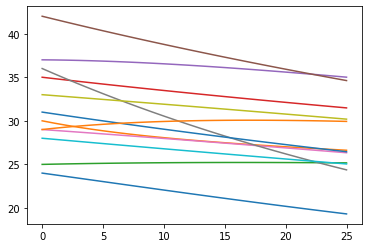

In [10]:
plt.plot(Diff)
plt.show()

## Mapa de calor

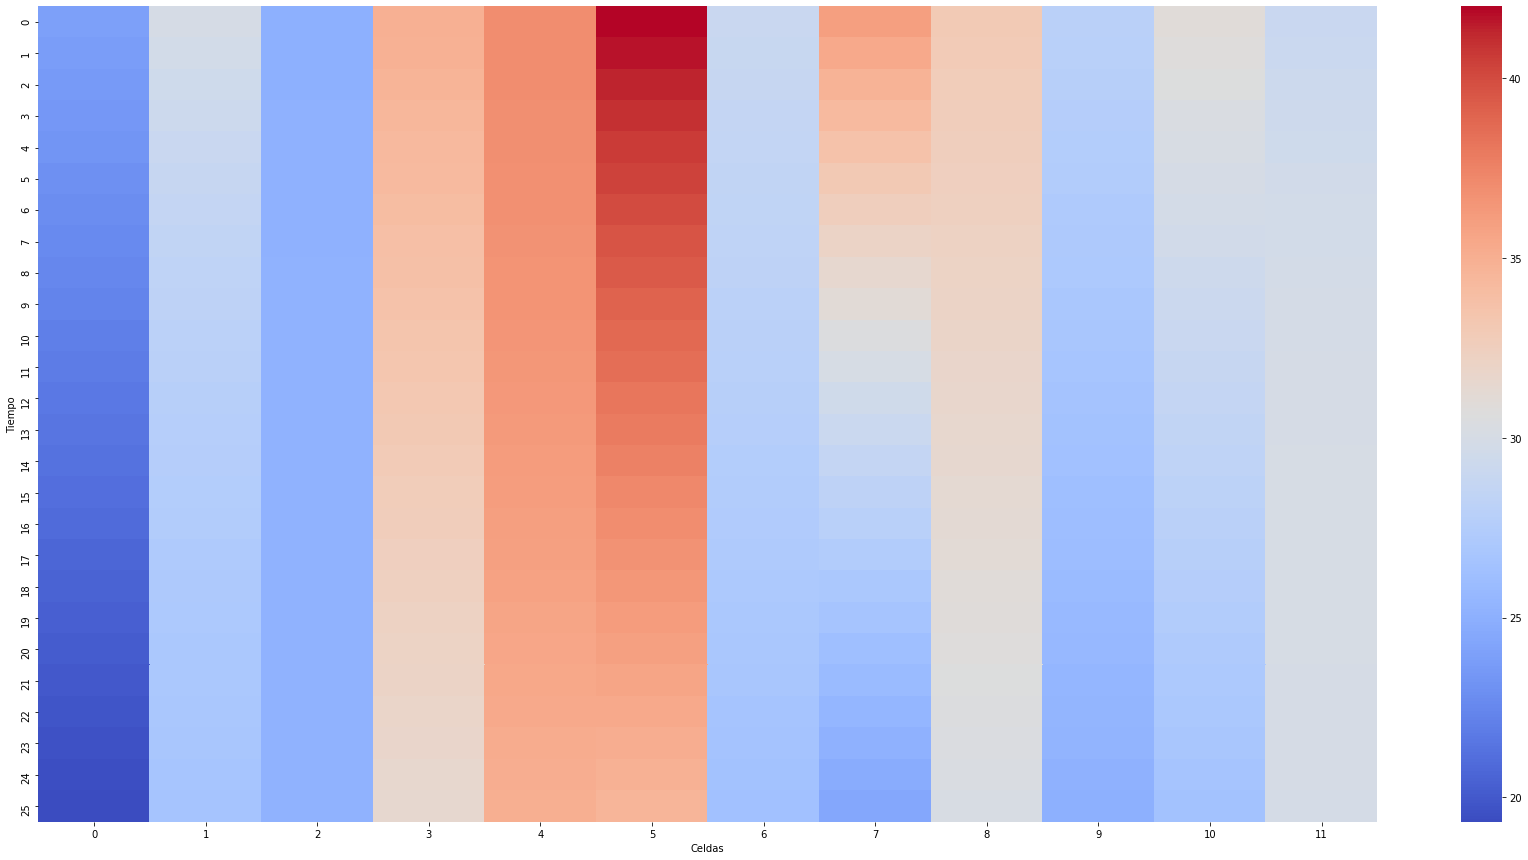

In [11]:
plt.figure(figsize =(30,15))
mapa = sns.heatmap(Diff,cmap='coolwarm')
figure = mapa.get_figure()
figure.savefig('mapa_calor.png',dpi=400)
plt.xlabel('Celdas')
plt.ylabel('Tiempo')
plt.show()